<a href="https://colab.research.google.com/github/yoramabbou770/AICourseRoad2/blob/main/droneBirdsandOtheripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

now you are an expert in python programmation with keras on google colab for deep learning.
Data Preprocessing:

Extract object locations using the labels.
Crop images around drones or birds and resize them to 32x32.
For the 'other' class, crop a random 32x32 part of each image.
Apply augmentations like random flip, color jitter, and rotation.
Save processed images and labels.
Show examples of the augmentations made on the images.
By the end of this stage, you should have 3 folders, one for each class containing the corresponding images.

In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess data
def load_and_preprocess_data(data_path, output_path):
    # Create output folders if they don't exist
    for class_name in ['drone', 'bird', 'other']:
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

    # Iterate through the images
    for filename in os.listdir(data_path):
        if filename.endswith(".txt"):
            # Process YOLO labels
            label_path = os.path.join(data_path, filename)
            image_path = os.path.join(data_path, filename.replace(".txt", ".jpg"))

            with open(label_path, 'r') as file:
                lines = file.readlines()

                for line in lines:
                    # Extract object locations and class
                    class_id, x_center, y_center, width, height = map(float, line.split())

                    # Load the image
                    image = cv2.imread(image_path)
                    image_h, image_w, _ = image.shape

                    # Calculate bounding box coordinates
                    x_min = int((x_center - width / 2) * image_w)
                    y_min = int((y_center - height / 2) * image_h)
                    x_max = int((x_center + width / 2) * image_w)
                    y_max = int((y_center + height / 2) * image_h)

                    # Crop images around drones or birds and resize them to 32x32
                    cropped_image = image[y_min:y_max, x_min:x_max]
                    resized_image = cv2.resize(cropped_image, (32, 32))

                    # Save processed images and labels to corresponding folders
                    class_name = 'drone' if class_id == 0 else 'bird' if class_id == 1 else 'other'
                    output_folder = os.path.join(output_path, class_name)
                    cv2.imwrite(os.path.join(output_folder, f"{filename.replace('.txt', '_')}.jpg"), resized_image)

        else:
            # For the 'other' class, crop a random 32x32 part of each image
            image_path = os.path.join(data_path, filename)

            # Load the image
            image = cv2.imread(image_path)
            image_h, image_w, _ = image.shape

            # Randomly crop a 32x32 part
            rand_x = np.random.randint(0, image_w - 32)
            rand_y = np.random.randint(0, image_h - 32)
            cropped_image = image[rand_y:rand_y + 32, rand_x:rand_x + 32]

            # Save processed images and labels to corresponding folders
            output_folder = os.path.join(output_path, 'other')
            cv2.imwrite(os.path.join(output_folder, f"{filename.replace('.jpg', '_')}.jpg"), cropped_image)

# Load and preprocess data
load_and_preprocess_data("/content/drive/MyDrive/bird_data", "/content/Task6/processed_data")
load_and_preprocess_data("/content/drive/MyDrive/drone_data", "/content/Task6/processed_data")

Build and Train a CNN Classifier Model:

Convert processed images into a TensorFlow dataset.
Split the dataset into train and test sets.
Use Keras to build a simple CNN classifier
Train the model and evaluate performance; Display the accuracy of the trained model on the test set.
Visualization and Analysis:

Plot accuracy and loss graphs
Plot a confusion matrix

Epoch 1/10
394/394 [==============================] - 15s 32ms/step - loss: 0.9444 - accuracy: 0.7562 - val_loss: 0.4307 - val_accuracy: 0.8679
Epoch 2/10
394/394 [==============================] - 13s 34ms/step - loss: 0.3742 - accuracy: 0.8695 - val_loss: 0.2295 - val_accuracy: 0.9257
Epoch 3/10
394/394 [==============================] - 13s 34ms/step - loss: 0.3293 - accuracy: 0.8893 - val_loss: 0.2378 - val_accuracy: 0.9156
Epoch 4/10
394/394 [==============================] - 13s 32ms/step - loss: 0.2765 - accuracy: 0.9077 - val_loss: 0.2114 - val_accuracy: 0.9187
Epoch 5/10
394/394 [==============================] - 17s 44ms/step - loss: 0.2372 - accuracy: 0.9192 - val_loss: 0.1923 - val_accuracy: 0.9498
Epoch 6/10
394/394 [==============================] - 14s 35ms/step - loss: 0.2209 - accuracy: 0.9269 - val_loss: 0.1575 - val_accuracy: 0.9422
Epoch 7/10
394/394 [==============================] - 14s 34ms/step - loss: 0.1968 - accuracy: 0.9361 - val_loss: 0.1412 - val_accuracy:

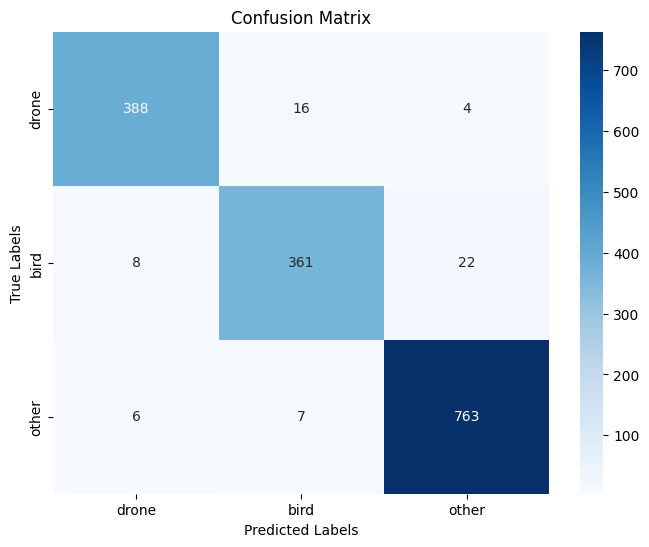

1/1 [==============================] - 0s 33ms/step
Example 1: True Label: drone, Predicted Label: drone
Example 2: True Label: other, Predicted Label: other
Example 3: True Label: other, Predicted Label: other
Example 4: True Label: drone, Predicted Label: drone
Example 5: True Label: other, Predicted Label: other
Example 6: True Label: bird, Predicted Label: bird
Example 7: True Label: other, Predicted Label: other
Example 8: True Label: other, Predicted Label: other
Example 9: True Label: bird, Predicted Label: bird
Example 10: True Label: bird, Predicted Label: bird


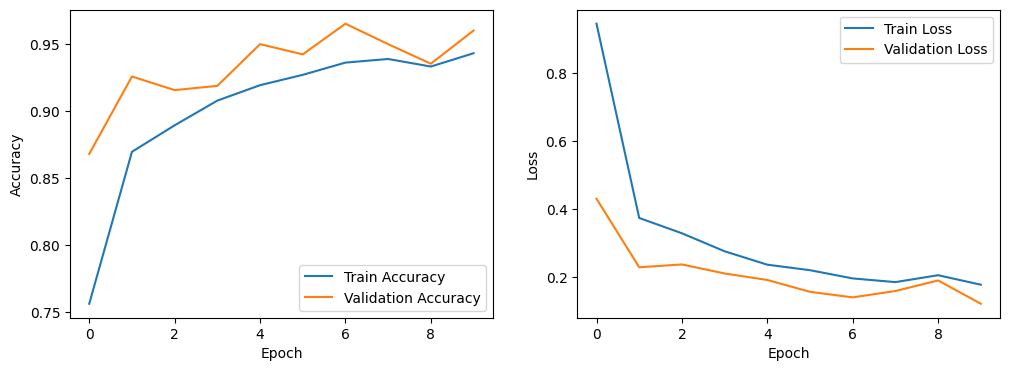

In [8]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tensorflow.keras.models import load_model
from io import BytesIO

# Function to create and train the CNN model
def build_and_train_model(data_path):
    # Load processed data
    images = []
    labels = []

    for class_name in ['drone', 'bird', 'other']:
        class_path = os.path.join(data_path, class_name)
        for filename in os.listdir(class_path):
            image = cv2.imread(os.path.join(class_path, filename))
            images.append(image)
            labels.append(class_name)

    # Convert images to NumPy array
    images = np.array(images)

    # Convert labels to one-hot encoding
    label_dict = {'drone': 0, 'bird': 1, 'other': 2}
    labels = [label_dict[label] for label in labels]
    labels = to_categorical(labels, num_classes=3)

    # Split dataset into train and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Build a simple CNN classifier using Keras
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Use ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2]
    )

    # Train the model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=10,
                        validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Get predictions for the test set
    test_predictions = model.predict(X_test)
    test_predicted_labels = np.argmax(test_predictions, axis=1)
    test_true_labels = np.argmax(y_test, axis=1)

    # Plot confusion matrix
    conf_mat = confusion_matrix(test_true_labels, test_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['drone', 'bird', 'other'], yticklabels=['drone', 'bird', 'other'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Explicitly see predictions on a few examples from the validation set
    num_examples_to_show = 10
    val_predictions = model.predict(X_val[:num_examples_to_show])
    val_predicted_labels = np.argmax(val_predictions, axis=1)

    for i in range(num_examples_to_show):
        true_label = np.argmax(y_val[i])
        predicted_label = val_predicted_labels[i]
        class_names = {0: 'drone', 1: 'bird', 2: 'other'}

        print(f"Example {i + 1}: True Label: {class_names[true_label]}, Predicted Label: {class_names[predicted_label]}")

    # Plot accuracy and loss graphs
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

# Build and train the CNN model
build_and_train_model("/content/Task6/processed_data")

Plot me the images of each class

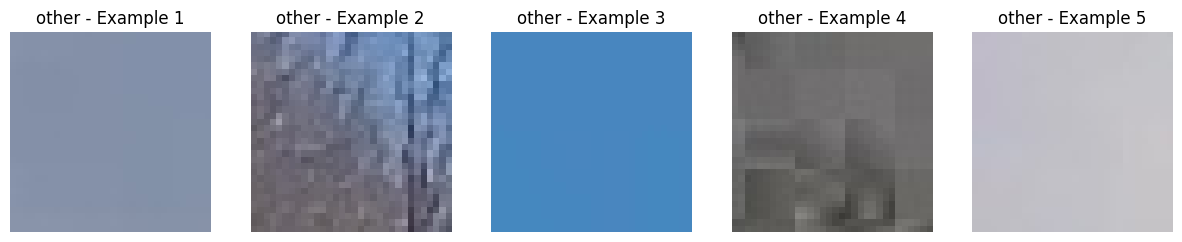

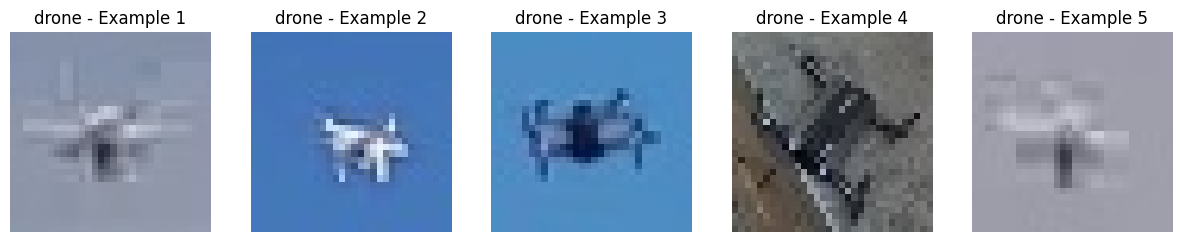

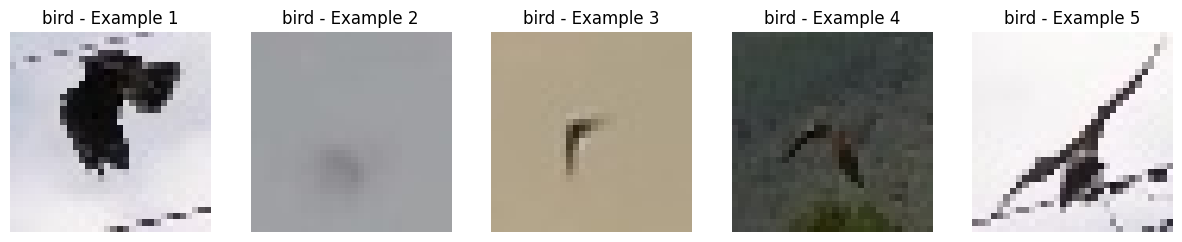

In [5]:
import matplotlib.pyplot as plt

# Function to plot sample images
def plot_samples(data_path, num_samples=5, class_name='other'):
    class_path = os.path.join(data_path, class_name)
    sample_files = os.listdir(class_path)[:num_samples]

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        image_path = os.path.join(class_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f'{class_name} - Example {i + 1}')
        plt.axis('off')

    plt.show()

# Plot sample images from the 'other' class
plot_samples("/content/Task6/processed_data", num_samples=5, class_name='other')
# Plot sample images from the 'drone' class
plot_samples("/content/Task6/processed_data", num_samples=5, class_name='drone')
# Plot sample images from the 'bird' class
plot_samples("/content/Task6/processed_data", num_samples=5, class_name='bird')